In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from keras import Sequential, callbacks, layers, optimizers, activations

from beast_chess.neural_networks import NetInputFactory, NetInputVersion
from notebooks.infra import Constants, PgnConverter, save_onnx_with_metadata, set_seed

In [2]:
model_version = NetInputVersion.V2

get_input = NetInputFactory.from_version(model_version)
x_data, y_data = PgnConverter.load_training_data_from_file(
    Constants.DATA_PATH / "evaluated" / "evaluated_macurek.txt", get_input=get_input
)

Loading training data from D:\code\beast\data\evaluated\evaluated_macurek.txt...
Loading took 0 seconds.
Loaded 13349 training data.


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - acc: 0.1115 - loss: 0.3569 - mae: 0.4996 - mape: 17731188.0000 - val_acc: 0.1131 - val_loss: 0.3775 - val_mae: 0.5162 - val_mape: 337007.5000


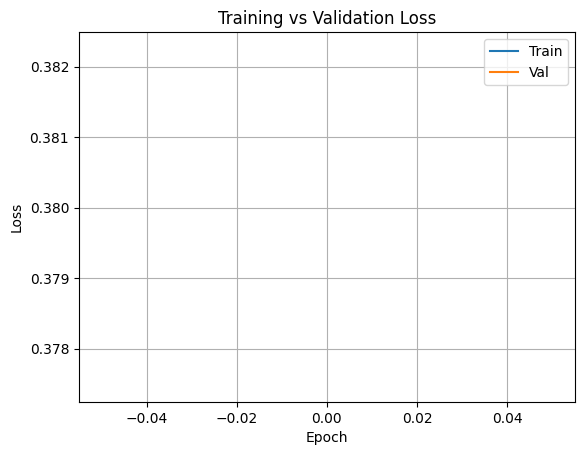

In [3]:
set_seed(42)

model = Sequential([
    layers.Input(x_data[0].shape),
    layers.Conv2D(128, kernel_size=3),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2D(256, kernel_size=3),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Flatten(),
    layers.Dense(256),
    layers.LeakyReLU(),
    layers.Dense(1, activation=activations.sigmoid),
])

adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss="mse", metrics=["acc", "mape", "mae"])
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=200)

history = model.fit(
    x_data,
    y_data,
    epochs=1,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1,
)

plt.figure()
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(visible=True)
plt.show()

In [9]:
save_onnx_with_metadata(model, "test_model", x_data[0], Path(), model_version=model_version.name)

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x0000018469881800>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
